
# 1. Setup the libraries

### Import the fastai library

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

### Import all the other libraries needed

In [32]:
import os # Create directories, list files
import zipfile # Extract compressed files
import numpy as np # Linear algebra, sorting and selecting
import pandas as pd # Dataframes and csv I/O
import matplotlib.pyplot as plt # Plotting histograms
from math import exp

### Github push

In [45]:
os.system("git add happy_whale_kernel.ipynb")
os.system("git commit -m 'Basic structure'")
os.system()

1

<br>
<br>
# 2. Setup the environment

### Environment

```
./input
│   train.csv    
│
└─── train
│   │   train_whale1.jpg
│   │   train_whale2.jpg
│   
│   
└─── test
│   │   test_whale1.jpg
│   │   test_whale2.jpg
│  
│   
└─── submission
    │   submission1.csv
    │   submission2.csv
```

### Initialize the enviroment variables

In [35]:
INPUT_DIR = ".\input\prova"
DOWNLOAD_DIR = "C:\\Users\\David\\.kaggle\\competitions\\whale-categorization-playground"

### Move the train-csv file and create the submission directory

In [39]:
if not os.path.exists(INPUT_DIR+"\\submission"): 
    os.mkdir(INPUT_DIR+"\\submission")
    

### Download the data from kaggle

Instructions to use the kaggle API: https://github.com/Kaggle/kaggle-api

In [8]:
if (os.system("kaggle competitions download -c whale-categorization-playground") == 0): print("Files ready")

Files ready


### Extract the data to the input directory

In [38]:
os.listdir(DOWNLOAD_DIR)

print("Extracting the training set...")
train_zip = zipfile.ZipFile(DOWNLOAD_DIR+"\\train.zip", mode="r")
train_zip.extractall(INPUT_DIR)
train_zip.close()

print("Extracting the test set...")
test_zip = zipfile.ZipFile(DOWNLOAD_DIR+"\\test.zip", mode="r")
test_zip.extractall(INPUT_DIR)
test_zip.close()

print("All files extracted succesfully")

Extracting the training set...
Extracting the test set...
All files extracted succesfully


Create the directories of the environment

Use kaggle cli to request the train and test files

Check the current directories in the input directory are correct

In [42]:

os.listdir(INPUT_DIR)


['submission', 'test', 'train']

# 3. Preliminary data exploration

Generate the pandas dataframe that will link each image to the corresponding whale from the csv file.
Show some basic info.

In [7]:
train_df = pd.read_csv(INPUT_DIR + "/train.csv")
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
Image    9850 non-null object
Id       9850 non-null object
dtypes: object(2)
memory usage: 154.0+ KB


,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


<br>
Load a random whale image to welcome us.

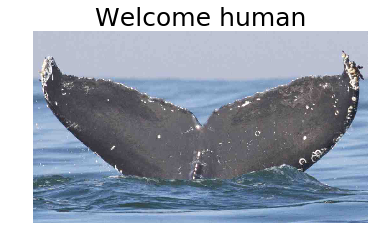

In [39]:
welcoming_whale = train_df.sample(1)["Image"].values[0]
image = plt.imread(f'{INPUT_DIR}/train/{welcoming_whale}')
image_plot = plt.imshow(image)
plt.axis("Off")
title = plt.title("Welcome human", fontsize=25)


Create a function to retrieve n whales from the dataset.

In [7]:
def get_random_whales(n):
    """Returns iterable of n lists of random whale images and whale id pairs from the training dataset
        [img_name1, img1], [img_name2, img2], ..., [img_name3, img3]
    """
    train_sample = train_df.sample(n)
    identifiers = [whale_id for whale_id in train_sample["Id"]]
    images = [plt.imread(f'{INPUT_DIR}/train/{image_name}')  for image_name in train_sample["Image"]]
    whales = zip(identifiers, images)
    return whales

Create a function to display n whales with the corresponding identifier.

In [8]:
def plot_random_whales(n_whales):
    """Plots n random whales with its corresponding identifier
    """
    whales = get_random_whales(n_whales)
    columns = 5
    rows = (n_whales // columns) + 1
    width, height = columns * 3, rows * 3
    figure = plt.figure(figsize=(width,height))
    for i, whale in enumerate(whales):
        subplot = figure.add_subplot(rows,columns,i+1)
        subplot.axis("Off")
        plt.title(whale[0])
        plt.imshow(whale[1])

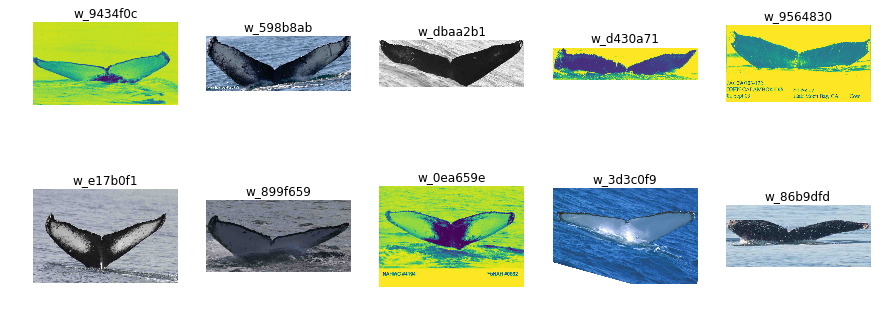

In [9]:
plot_random_whales(10)

Time to analyze our dataset. First we will check how many categories we have.

In [174]:
n_train_images = train_df.size
categories = train_df["Id"].unique()
n_categories = len(train_df["Id"].unique())
ratio_images_per_category = n_test_images // n_categories
print(f"Number of test images: {n_test_images}")
print(f"Number of categories: {n_categories}")
print(f"Ratio of mean images per category: {ratio_images_per_category}")

Number of test images: 19700
Number of categories: 4251
Ratio of mean images per category: 4


As we can see, we don't have many test cases per category. Let's plot a histogram to see it further

In [176]:
buckets = train_df["Id"].value_counts().values
unique, counts = np.unique(buckets, return_counts=True)
print(counts)

[2220 1034  492  192  102   61   40   23   21    9    7    7    9    5    4    5    4    2    2    1    3
    3    1    1    1    1    1]


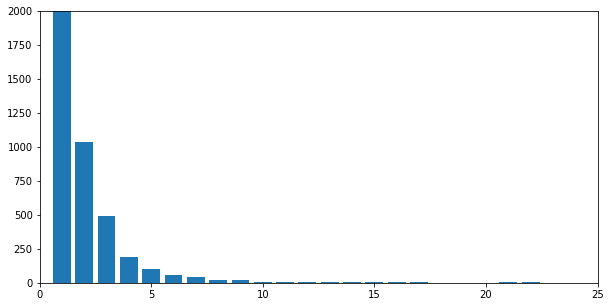

In [172]:
plt.figure(figsize=(10, 5))
plt.bar(unique, counts)
plt.axis((0,25,0,2000))
plt.show()

One huge problem with this dataset is the number of images per category.
 - First, it's very hard to generalize from such small number of cases
 - Second, if we include all the images for one particular category in the validation set, then our trained network won't have the right output dimensionality (this will break our model as we will see later)

For that reason we will do some aggresive data augmentation. 

In [177]:
arch = resnet34
tfms = tfms_from_model(resnet34, 224, aug_tfms=transforms_side_on, max_zoom=1.1)
val_idxs_a = get_cv_idxs(9850, val_pct=0.001)
data = ImageClassifierData.from_csv(path="./input", folder="train", val_idxs=val_idxs_a, csv_fname="./input/train.csv", test_name="test", skip_header=True, tfms=tfms_from_model(resnet34, 224, aug_tfms=transforms_side_on, max_zoom=1.1))

100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


 91%|█████████ | 140/154 [00:01<00:00, 93.02it/s, loss=70.9]


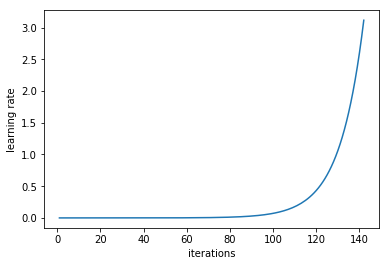

In [178]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find()
learn.sched.plot_lr()

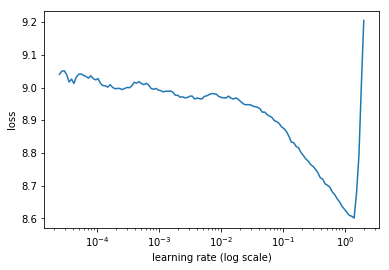

In [179]:
learn.sched.plot()

In [180]:

learn.fit(0.1, 2)

epoch      trn_loss   val_loss   accuracy                    
    0      7.856618   7.812098   0.0       
    1      6.796409   7.159394   0.0                         



[7.1593943, 0.0]

AttributeError: 'LossRecorder' object has no attribute 'plot'

As Andrew said, building a succesfull neural network is an iterative process. We shouldn't expect to come up with a magical idea that will make a great network from the start. Also we shouldn't make decisions based on "gut feelings" or "divine visions".

Insted, our first priority is to build a basic and dirty classfier that will output something.
That something doesn't have to be great, it can be just above garbage, but thats more than enough to extract some metrics that will drive our decisions much better.
For that reason, I won't bother for augmentations, tricky algorithms or anything more than the very basics at this point. I will just focus on predicting something I can upload to kaggle.

We set the is_test flag to True to tell the model to predict on the test set.<br>
learn.predict() outputs the logarithm of the activation of the last layer for each category.

So, the activation ranges from 0 to 1:<br>
0 corresponds to a very unlikely match<br>
1 corresponds to a almost certain match

Applying a logarithm to the activation value we get an output that ranges from -inf to 0:<br>
-inf corresponds to a very unlikely match<br>
0 corresponds to a almost certain match


Taking this into consideration we can now compute the prediction for one image of the test set.<br>
The prediction is represented as an array of the logarithms of the activations for each of the categories  sorted in the appearing order in the csv file.<br>
In this case, the model has 4250 categories, so the output will be an array of 4250 items.<br>
[-7.12, -8.23, -3.89, ... ,-10.67] --> len(one_prediction) == 4250

So the prediction for m test cases will result in a list of the predictions of each image for each category.<br>
It can be thought as a m*c matrix


In [181]:
test_name = "test"
log_predictions_test = learn.predict(is_test=True)

In this kaggle competition we are told to give the 5 more likely categories for each test case.
We extract the 5 highest values (closest to 0) and the corresponding category indexes for each test case prediction.
Now we match the indexes with the category name from the original "Id" column of the dataframe.
Finally, we write our predictions in a csv file.


In [182]:
def categories_wrapper(prediction):
    case_predicted_categories = np.argpartition(prediction, -5)[-5:]
    return case_predicted_categories

In [183]:
type(log_predictions_test)
print(len(log_predictions_test[0]))
print(log_predictions_test[0][4249])
#np.argpartition(log_predictions_test[0], -5)[-5:]
predicted_categories = list(map(categories_wrapper, log_predictions_test))
print(predicted_categories[4210])

4251
-9.297876
[4183 1932 2234 2620    0]


In [184]:
def categories_from_index(prediction):
    pred_cat = []
    for index in prediction:
        pred_cat.append(categories[index])
    return pred_cat
    

In [185]:
predicted_cat = list(map(categories_from_index, predicted_categories))
predicted_cat[3]


['w_80171b9', 'w_dd52cfc', 'w_6dd7c3d', 'w_01a4234', 'w_e15442c']

In [186]:
predicted_format_df = list(map(" ".join, predicted_cat))
print(predicted_format_df[1000])
list_name_test_images = os.listdir("./input/test")
predictions_df  = pd.DataFrame(data = {"Image":list_name_test_images, "Id": predicted_format_df}, columns=["Image", "Id"])
predictions_df.to_csv("submission2.csv",index=False)

w_4457d27 w_e15442c w_578a509 w_6d7c852 w_14c8f15
